# week 3 HW

- Universal Approaximation Theorem: neural network with a **single hidden layer** containing a finite number of neurons can **approximate any continuous function**

- 실제로 Universal Approaximation Theorem이 성립하는 것인지 코드로 구현해봅시다! 

## 목차
1. g(x) 생성
2. one hidden layer model with Heaviside function
3. one hidden layer model with Sigmoid activation function
4. one hidden layer model with ReLU activation function
5. one hidden layer model with Softplut activation function

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math

# 1. g(x) 생성

- 우리가 근사하고자 하는 임의의 연속 함수 g(x)를 생성합니다. 

- 이번 실습에서는 여기서는 아래 사이트를 참고하여 $$g(x) = 3sin(x)cos(x)(6x^2+3x^3+x)tan(x)$$  라는 함수를 사용하도록 하겠습니다. 

- 다만 Universal Approximation Theorem 은 임의의 연속함수 g(x)에 대해 항상 근사가 가능하다는 것이기 때문에, 시간이 여유가 있으신 분들은  g(x)의 형태를 바꿔보며 실제로 어떤 함수이든지 근사가 가능하다는 점을 확인해보셔도 좋을 것 같습니다 :)

Text(0.5, 1.0, 'g(x)')

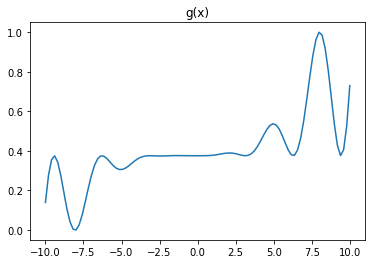

In [2]:
x = np.linspace(-10, 10, 100)
y = 3*np.sin(x)*np.cos(x)*(6*x**2+3*x**3+x**1)*np.tan(x) # g(x)
y = (y - y.min()) / (y.max() - y.min()) # min-max scaling

plt.plot(x, y)
plt.title("g(x)")

In [3]:
n_neuron = 200
input_dim = 1
output_dim = 1

# 2. One hidden layer model with Heaviside activation function

heaviside function을 activation function으로 하는 딥러닝 모델을 사용해 g(x)를 근사해봅시다. 

딥러닝 모델의 구조를 그림으로 나타내면 아래와 같습니다. 



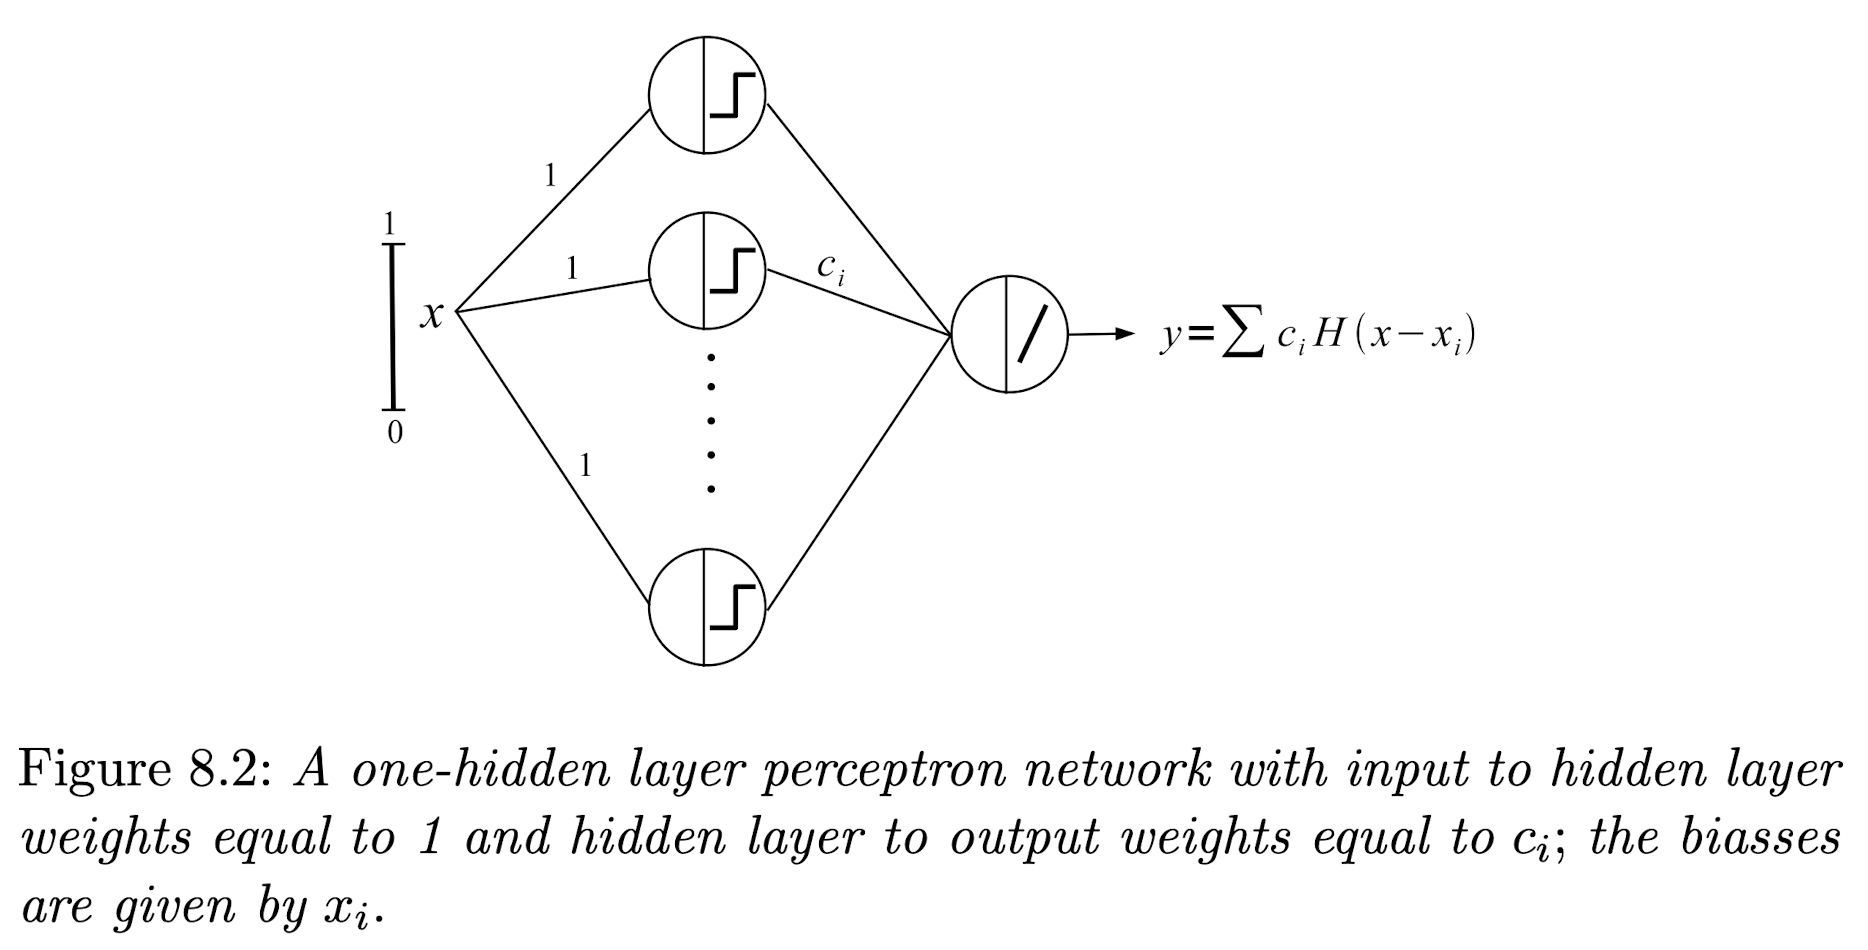

In [4]:
x = torch.FloatTensor(x) # input
y = torch.FloatTensor(y) # output

b = torch.zeros(100, requires_grad = True) # input bias
c = torch.zeros(100, requires_grad = True) # output weight

threshold = torch.FloatTensor([0])

Q. 위 그림을 보며 아래 코드에서 hypothesis가 왜 저렇게 정의되는지 생각해봅시다.   
A. target variable y를 이론적으로 헤비사이드 활성화 함수에 x-b (b는 bias)를 넣은 출력값의 선형결합으로 정의할 수 있기 때문이다.

In [5]:
optimizer = optim.SGD([b, c], lr = 0.1)

for epoch in range(5001):
  hypothesis = sum(c * torch.heaviside(x - b, values = threshold)) 
  cost = torch.mean((hypothesis - y) ** 2)
  
  optimizer.zero_grad()
  cost.backward() 
  optimizer.step()

  if epoch % 500 == 0:
      print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
          epoch, b.item(), c.item(), cost.item()
      ))

RuntimeError: derivative for aten::heaviside is not implemented

**에러가 발생해도 당황하지 마세요!**

Q. 어떤 에러가 발생했나요? Heaviside function을 activation function으로 사용해도 g(x) 근사는 가능하지만, 현실에서 Heaviside function 을 잘 사용하지 않는 이유를 에러 발생 이유와 연결지어 생각해봅시다! 

A. 헤비사이드 함수는 0을 제외한 다른 구간에서 미분값이 0이 되기 때문에 역전파가 안 된다.

# 3. One hidden layer model with Sigmoid activation function

sigmoid function을 activation function으로 하는 딥러닝 모델을 사용해 g(x)를 근사해봅시다. 

딥러닝 모델의 구조를 그림으로 나타내면 아래와 같습니다. 

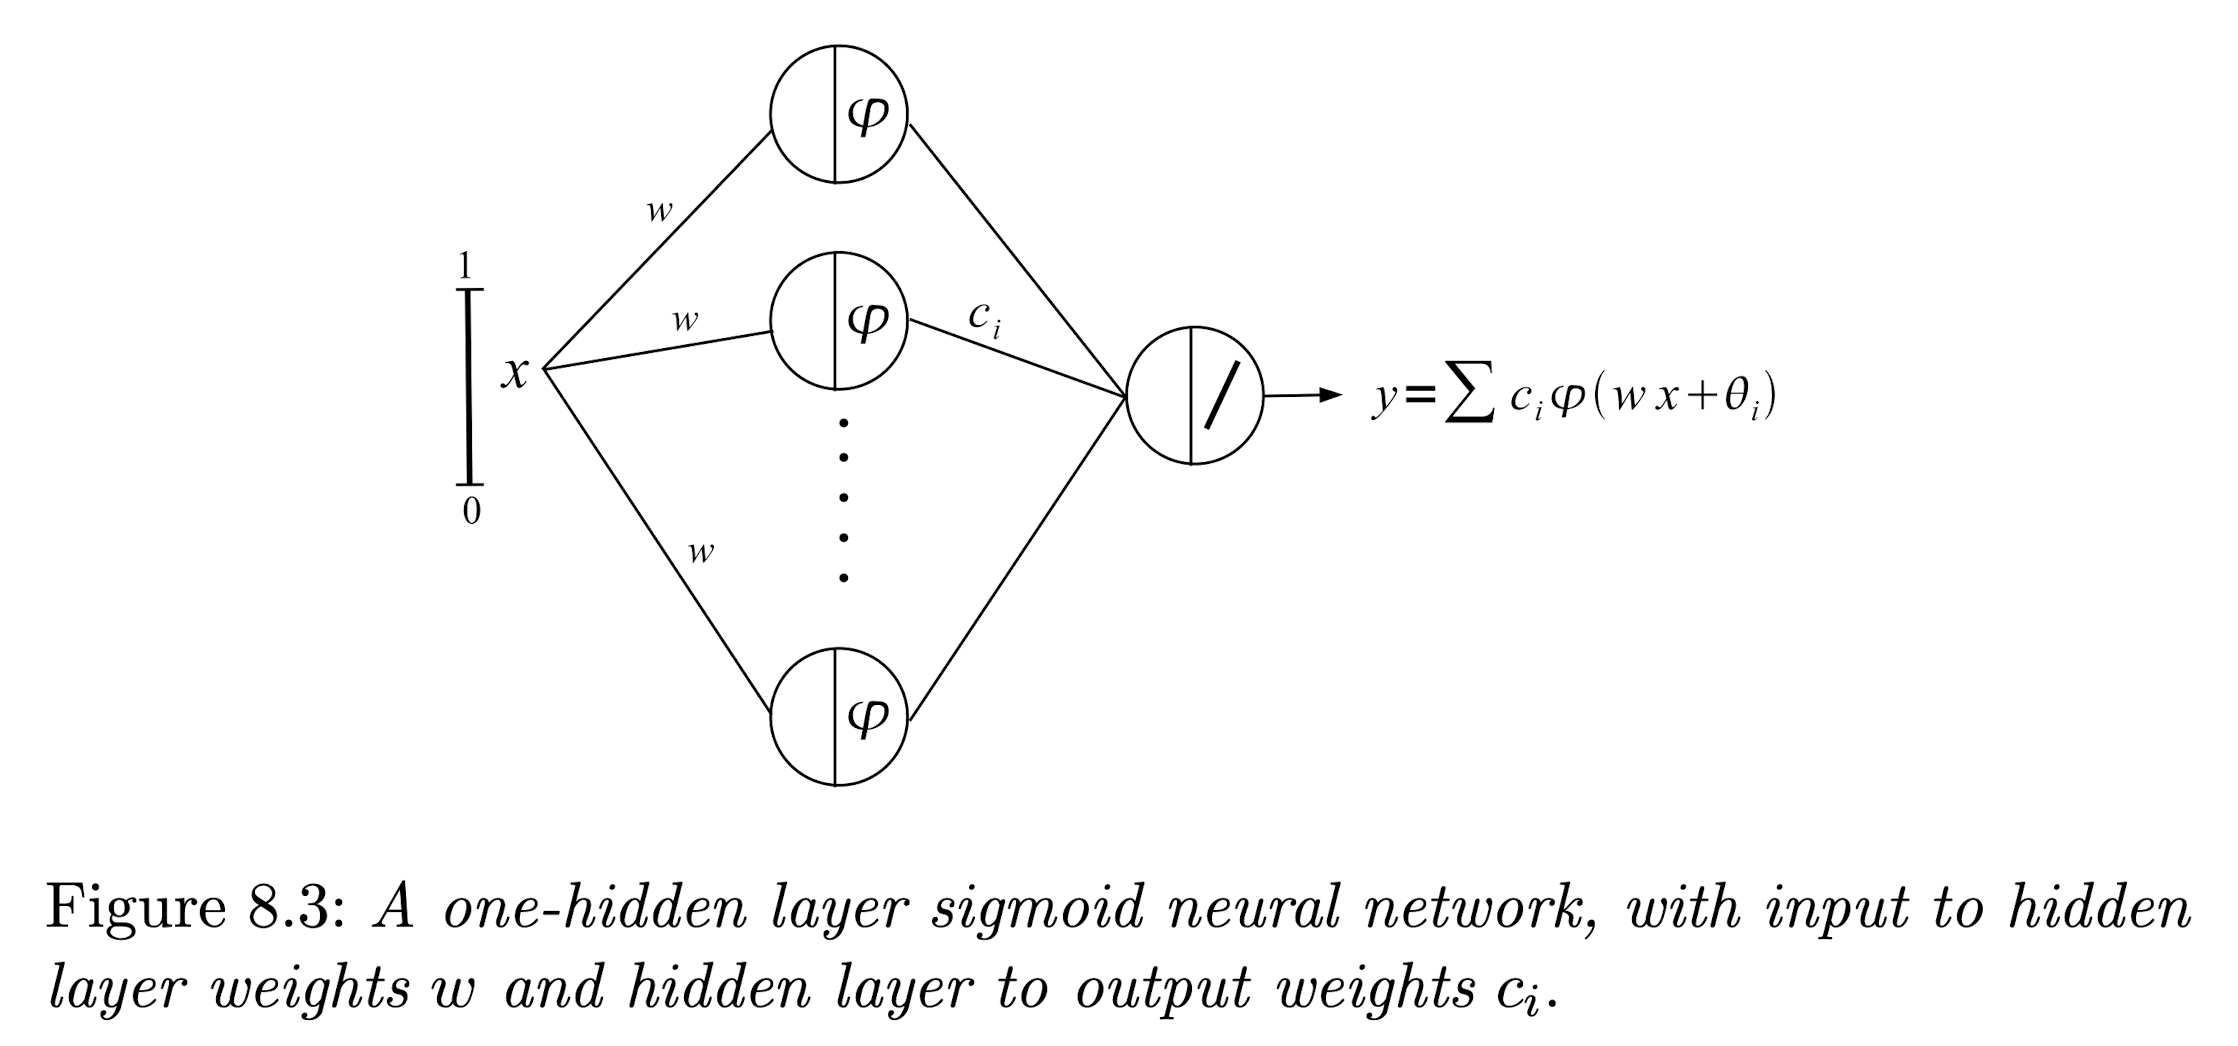

In [6]:
x = x.view(100, -1)
y = y.view(100, -1)
x.size()

torch.Size([100, 1])

In [7]:
# one hidden layer model with sigmoid activation function

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, n_neuron),
    torch.nn.Sigmoid(),
    torch.nn.Linear(n_neuron, output_dim))

In [8]:
# Set loss and optmizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [9]:
# start training
for i in range(5000):
  
    outputs = model(x)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 500 == 0:
      print(i, loss.item())

0 0.3052813410758972
500 0.01311956625431776
1000 0.012629351578652859
1500 0.012742849998176098
2000 0.011815512552857399
2500 0.011133618652820587
3000 0.009242018684744835
3500 0.049000125378370285
4000 0.00563399214297533
4500 0.004933445248752832


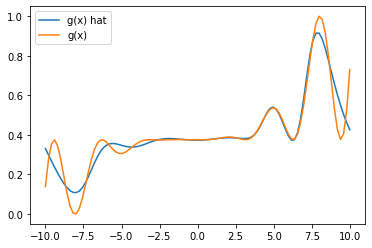

In [10]:
with torch.no_grad(): 
    prediction = model(x)
    plt.plot(x, prediction, label = "g(x) hat")
    plt.plot(x, y, label = "g(x)")
    plt.legend()

Q. 위 그래프를 보며 sigmoid function을 사용해 g(x) 근사가 잘 되었는지 얘기해봅시다.  
A. 양끝 구간을 제외하고는 꽤 가깝게 근사가 되었다.

# 4. One hidden layer model with ReLu activation function

ReLU function을 activation function으로 하는 딥러닝 모델을 사용해 g(x)를 근사해봅시다. 

sigmoid function을 사용한 모델에서 activation function만 바꿔주면 됩니다.

In [11]:
# one hidden layer model with ReLu activation function

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, n_neuron),
    torch.nn.ReLU(),
    torch.nn.Linear(n_neuron, output_dim))

In [12]:
# Set loss and optmizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [13]:
# start training
for i in range(5000):
  
    outputs = model(x)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 500 == 0:
      print(i, loss.item())

0 0.25738760828971863
500 0.008553029038012028
1000 0.006783256307244301
1500 0.005444676149636507
2000 0.00456143356859684
2500 0.007791465613991022
3000 0.004944934975355864
3500 0.01185736432671547
4000 0.005895145703107119
4500 0.003418089123442769


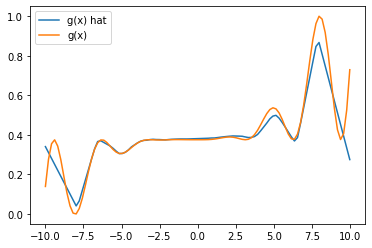

In [14]:
with torch.no_grad(): 
    prediction = model(x)
    plt.plot(x, prediction, label = "g(x) hat")
    plt.plot(x, y, label = "g(x)")
    plt.legend()

Q. 위 그래프를 보며 Relu를 사용해 g(x) 근사가 잘 되었는지 확인해봅시다.   
A. sigmoid보다 error 값이 조금 더 작다. 다만 양끝 구간에선 여전히 차이가 있다.

# One hidden layer model with SoftPlus activation function

SoftPlus function을 activation function으로 하는 딥러닝 모델을 사용해 g(x)를 근사해봅시다. 

Relu function을 사용한 모델에서 activation function만 바꿔주면 됩니다.

In [127]:
# one hidden layer model with softplus activation function
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, n_neuron),
    torch.nn.Softplus(),
    torch.nn.Linear(n_neuron, output_dim))

In [128]:
# Set loss and optmizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.99)

In [129]:
# start training
for i in range(5000):
  
    outputs = model(x)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 500 == 0:
      print(i, loss.item())

0 0.6866225600242615
500 0.017681632190942764
1000 0.013924169354140759
1500 0.012150262482464314
2000 0.011047380045056343
2500 0.01011849194765091
3000 0.00916075985878706
3500 0.008092723786830902
4000 0.00698291789740324
4500 0.007753985468298197


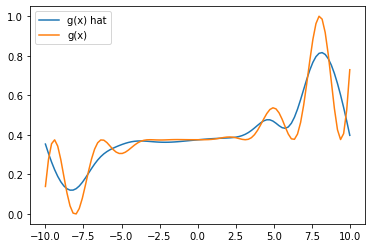

In [130]:
with torch.no_grad(): 
    prediction = model(x)
    plt.plot(x, prediction, label = "g(x) hat")
    plt.plot(x, y, label = "g(x)")
    plt.legend()

Q. 위 그래프를 보며 softplus를 사용한 g(x)를 근사가 잘 이루어졌는지 얘기해봅시다. 

혹시 근사가 잘 되지 않는다면 learning rate를 조금 조정해봅시다. 

A. softplus의 성능은 sigmoid나 relu보다 좋지 않았다. 추정된 함수가 target function의 경향성과는 일치하지만 세밀하게는 꽤 차이가 있었다. learning rate를 높이면 결과가 약간 개선되었다.